In [97]:
from typing import *
import libcst as cst
import networkx as nx
import pandas as pd
import numpy as np

In [78]:
nx.__version__

'2.8.5'

In [65]:
file_path = 'play.py'

In [66]:
line_number = 9
var_name = 'd'

In [67]:
file_lines = open(file_path, 'r').readlines()

In [68]:
file_cst = cst.parse_module(open(file_path, 'r').read())

In [69]:
file_lines

['class A:\n',
 '    def __init__(self):\n',
 '        pass\n',
 '\n',
 '    def run(self):\n',
 '        a = 5\n',
 '        b = a + 7 + 5.0\n',
 '        ll = a + 6.4\n',
 '        c = a + b + 3\n',
 '        d = b + c\n']

In [70]:
# file_cst

In [141]:
class FunctionCollector(cst.CSTVisitor):
    def __init__(self):
        self._names: List[str] = []
    
    def visit_FunctionDef(self, node: cst.FunctionDef) -> None:
#         wrapper = cst.metadata.MetadataWrapper(node)
        collector = AssignCollector()
#         wrapper.visit(collector)
        node.visit(collector)
        self._names.append(collector.names)
        pass

    def leave_FunctionDef(self, node: cst.FunctionDef) -> None:
        pass

In [145]:
class AssignCollector(cst.CSTVisitor):
#     METADATA_DEPENDENCIES = (cst.metadata.PositionProvider,)
    
    def __init__(self):
        self.names: List[str] = []
    
    def visit_Assign(self, node: cst.FunctionDef) -> None:
#         pos = self.get_metadata(cst.metadata.PositionProvider, node).start
        collector = ValueCollector()
        node.value.visit(collector)
        value_dict = {'names': collector.names, 'ints': collector.ints, 'floats': collector.floats}
#         self.names.append((node.targets[0].target.value, value_dict, pos.line))
        self.names.append((node.targets[0].target.value, value_dict))

In [146]:
class ValueCollector(cst.CSTVisitor):
    def __init__(self):
        self.names: List[str] = []
        self.ints: List[str] = []
        self.floats: List[str] = []
    
    def visit_Name(self, node: cst.FunctionDef) -> None:
        self.names.append(node.value)
        
    def visit_Integer(self, node: cst.FunctionDef) -> None:
        self.ints.append(node.value)
        
    def visit_Float(self, node: cst.FunctionDef) -> None:
        self.floats.append(node.value)

In [187]:
visitor = FunctionCollector()
# file_cst.visit(visitor)

In [148]:
visitor._names

[[],
 [('a', {'names': [], 'ints': ['5'], 'floats': []}),
  ('b', {'names': ['a'], 'ints': ['7'], 'floats': ['5.0']}),
  ('ll', {'names': ['a'], 'ints': [], 'floats': ['6.4']}),
  ('c', {'names': ['a', 'b'], 'ints': ['3'], 'floats': []}),
  ('d', {'names': ['b', 'c'], 'ints': [], 'floats': []})]]

In [79]:
a = visitor._names[1]
a

[('a', {'names': [], 'ints': ['5'], 'floats': []}),
 ('b', {'names': ['a'], 'ints': ['7'], 'floats': ['5.0']}),
 ('ll', {'names': ['a'], 'ints': [], 'floats': ['6.4']}),
 ('c', {'names': ['a', 'b'], 'ints': ['3'], 'floats': []}),
 ('d', {'names': ['b', 'c'], 'ints': [], 'floats': []})]

In [83]:
b = pd.DataFrame(a, columns=['assigned', 'data'])
b

,assigned,data
0,a,"{'names': [], 'ints': ['5'], 'floats': []}"
1,b,"{'names': ['a'], 'ints': ['7'], 'floats': ['5...."
2,ll,"{'names': ['a'], 'ints': [], 'floats': ['6.4']}"
3,c,"{'names': ['a', 'b'], 'ints': ['3'], 'floats':..."
4,d,"{'names': ['b', 'c'], 'ints': [], 'floats': []}"


In [85]:
b['assignee'] = b['data'].apply(lambda x: x['names'])

In [86]:
b

,assigned,data,assignee
0,a,"{'names': [], 'ints': ['5'], 'floats': []}",[]
1,b,"{'names': ['a'], 'ints': ['7'], 'floats': ['5....",[a]
2,ll,"{'names': ['a'], 'ints': [], 'floats': ['6.4']}",[a]
3,c,"{'names': ['a', 'b'], 'ints': ['3'], 'floats':...","[a, b]"
4,d,"{'names': ['b', 'c'], 'ints': [], 'floats': []}","[b, c]"


In [111]:
dg = nx.DiGraph()

In [112]:
var_names = set(list(b['assignee'].explode().dropna().unique()) + list(b['assigned'].unique()))
var_names

{'a', 'b', 'c', 'd', 'll'}

In [113]:
for name in var_names:
    dg.add_node(name)

In [114]:
for index, a_series in b.iterrows():
    if a_series['assignee']:
        for assignee in a_series['assignee']:
            dg.add_edge(assignee, a_series['assigned'])

In [115]:
dg

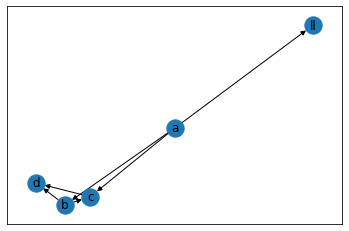

In [117]:
nx.draw_networkx(dg)

In [124]:
ancestors = nx.ancestors(dg, 'd')

In [126]:
b[b['assigned'].isin(ancestors)]

,assigned,data,assignee
0,a,"{'names': [], 'ints': ['5'], 'floats': []}",[]
1,b,"{'names': ['a'], 'ints': ['7'], 'floats': ['5....",[a]
3,c,"{'names': ['a', 'b'], 'ints': ['3'], 'floats':...","[a, b]"


In [129]:
print(file_cst.code)

class A:
    def __init__(self):
        pass

    def run(self):
        a = 5
        b = a + 7 + 5.0
        ll = a + 6.4
        c = a + b + 3
        d = b + c



In [153]:
class NamePrinter(cst.CSTVisitor):
    METADATA_DEPENDENCIES = (cst.metadata.PositionProvider,)

    def visit_Name(self, node: cst.Name) -> None:
        pos = self.get_metadata(cst.metadata.PositionProvider, node).start
        print(f"{node.value} found at line {pos.line}, column {pos.column}")

In [154]:
wrapper = cst.metadata.MetadataWrapper(cst.parse_module("x = 1"))
result = wrapper.visit(NamePrinter())

x found at line 1, column 0


In [155]:
wrapper = cst.metadata.MetadataWrapper(cst.parse_module(open(file_path, 'r').read()))
result = wrapper.visit(NamePrinter())

A found at line 1, column 6
__init__ found at line 2, column 8
self found at line 2, column 17
run found at line 5, column 8
self found at line 5, column 12
a found at line 6, column 8
b found at line 7, column 8
a found at line 7, column 12
ll found at line 8, column 8
a found at line 8, column 13
c found at line 9, column 8
a found at line 9, column 12
b found at line 9, column 16
d found at line 10, column 8
b found at line 10, column 12
c found at line 10, column 16


In [156]:
k = cst.parse_module(open(file_path, 'r').read())

In [167]:
# k.body[0]

In [166]:
wrapper = cst.metadata.MetadataWrapper(k)
# wrapper = cst.metadata.MetadataWrapper(k.body[0].name)
result = wrapper.visit(NamePrinter())

A found at line 1, column 6
__init__ found at line 2, column 8
self found at line 2, column 17
run found at line 5, column 8
self found at line 5, column 12
a found at line 6, column 8
b found at line 7, column 8
a found at line 7, column 12
ll found at line 8, column 8
a found at line 8, column 13
c found at line 9, column 8
a found at line 9, column 12
b found at line 9, column 16
d found at line 10, column 8
b found at line 10, column 12
c found at line 10, column 16


In [183]:
class FunctionCollector(cst.CSTVisitor):
    METADATA_DEPENDENCIES = (cst.metadata.PositionProvider,)
    def __init__(self):
        self._names: List[str] = []
        self.names: List[str] = []
    
    def visit_FunctionDef(self, node: cst.FunctionDef) -> None:
#         wrapper = cst.metadata.MetadataWrapper(node)
#         pos = self.get_metadata(cst.metadata.PositionProvider, node).start
#         collector = AssignCollector()
#         wrapper.visit(collector)
#         node.visit(collector)
#         self._names.append((collector.names, pos.line))
        pass

    def leave_FunctionDef(self, node: cst.FunctionDef) -> None:
        pass
    
    def visit_Assign(self, node: cst.FunctionDef) -> None:
        pos = self.get_metadata(cst.metadata.PositionProvider, node).start
        collector = ValueCollector()
        node.value.visit(collector)
        value_dict = {'names': collector.names, 'ints': collector.ints, 'floats': collector.floats}
        self.names.append((node.targets[0].target.value, value_dict, pos.line))
#         self.names.append((node.targets[0].target.value, value_dict))

In [184]:
class AssignCollector(cst.CSTVisitor):
    METADATA_DEPENDENCIES = (cst.metadata.PositionProvider,)
    
    def __init__(self):
        self.names: List[str] = []
    
    def visit_Assign(self, node: cst.FunctionDef) -> None:
        pos = self.get_metadata(cst.metadata.PositionProvider, node).start
        collector = ValueCollector()
        node.value.visit(collector)
        value_dict = {'names': collector.names, 'ints': collector.ints, 'floats': collector.floats}
#         self.names.append((node.targets[0].target.value, value_dict, pos.line))
        self.names.append((node.targets[0].target.value, value_dict))

In [191]:
visitor = FunctionCollector()
wrapper = cst.metadata.MetadataWrapper(file_cst)
jj = wrapper.visit(visitor)

In [192]:
visitor.names

[('a', {'names': [], 'ints': ['5'], 'floats': []}, 6),
 ('b', {'names': ['a'], 'ints': ['7'], 'floats': ['5.0']}, 7),
 ('ll', {'names': ['a'], 'ints': [], 'floats': ['6.4']}, 8),
 ('c', {'names': ['a', 'b'], 'ints': ['3'], 'floats': []}, 9),
 ('d', {'names': ['b', 'c'], 'ints': [], 'floats': []}, 10)]

In [194]:
b = pd.DataFrame(visitor.names, columns=['assigned', 'data', 'line'])
b['assignee'] = b['data'].apply(lambda x: x['names'])
b

,assigned,data,line,assignee
0,a,"{'names': [], 'ints': ['5'], 'floats': []}",6,[]
1,b,"{'names': ['a'], 'ints': ['7'], 'floats': ['5....",7,[a]
2,ll,"{'names': ['a'], 'ints': [], 'floats': ['6.4']}",8,[a]
3,c,"{'names': ['a', 'b'], 'ints': ['3'], 'floats':...",9,"[a, b]"
4,d,"{'names': ['b', 'c'], 'ints': [], 'floats': []}",10,"[b, c]"


In [196]:
var_names = set(list(b['assignee'].explode().dropna().unique()) + list(b['assigned'].unique()))
var_names

{'a', 'b', 'c', 'd', 'll'}

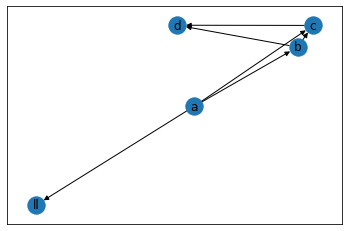

In [199]:
dg = nx.DiGraph()
for name in var_names:
    dg.add_node(name)
for index, a_series in b.iterrows():
    if a_series['assignee']:
        for assignee in a_series['assignee']:
            dg.add_edge(assignee, a_series['assigned'])
nx.draw_networkx(dg)

In [249]:
var_name = 'll'
ancestors = nx.ancestors(dg, var_name)
c = b[b['assigned'].isin(ancestors.union(set([var_name])))]
c

,assigned,data,line,assignee
0,a,"{'names': [], 'ints': ['5'], 'floats': []}",6,[]
2,ll,"{'names': ['a'], 'ints': [], 'floats': ['6.4']}",8,[a]


In [246]:
lines = open(file_path, 'r').readlines()
print("".join(lines))

class A:
    def __init__(self):
        pass

    def run(self):
        a = 5
        b = a + 7 + 5.0
        ll = a + 6.4
        c = a + b + 3
        d = b + c



In [250]:
print("".join(np.array(open(file_path, 'r').readlines())[c['line'].values- 1]))

        a = 5
        ll = a + 6.4



In [253]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
code = """
class A:
    def __init__(self):
        pass

    def run(self):
        a = 5
        b = a + 7 + 5.0
        ll = a + 6.4
        c = a + b + 3
        d = b + c
"""
# code = "print 'Hello World'"
print(highlight(code, PythonLexer(), HtmlFormatter()))

<div class="highlight"><pre><span></span><span class="k">class</span> <span class="nc">A</span><span class="p">:</span>
    <span class="k">def</span> <span class="fm">__init__</span><span class="p">(</span><span class="bp">self</span><span class="p">):</span>
        <span class="k">pass</span>

    <span class="k">def</span> <span class="nf">run</span><span class="p">(</span><span class="bp">self</span><span class="p">):</span>
        <span class="n">a</span> <span class="o">=</span> <span class="mi">5</span>
        <span class="n">b</span> <span class="o">=</span> <span class="n">a</span> <span class="o">+</span> <span class="mi">7</span> <span class="o">+</span> <span class="mf">5.0</span>
        <span class="n">ll</span> <span class="o">=</span> <span class="n">a</span> <span class="o">+</span> <span class="mf">6.4</span>
        <span class="n">c</span> <span class="o">=</span> <span class="n">a</span> <span class="o">+</span> <span class="n">b</span> <span class="o">+</span> 

In [7]:
# import streamlit as st
# from annotated_text import annotated_text
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
#
#
file_path = '/mnt/hgfs/dev/open_source_projects/alkh/notebooks/play.py'
lines = open(file_path).readlines()
#
# st.code("".join(np.array(lines)[[0, 4, 5]]))
#
# st.code("".join(np.array(lines)))

# import streamlit as st
# import streamlit.components.v1 as components

# bootstrap 4 collapse example
# components.html(
#     """
#     <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
#     <script src="https://code.jquery.com/jquery-3.2.1.slim.min.js" integrity="sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN" crossorigin="anonymous"></script>
#     <script src="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js" integrity="sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl" crossorigin="anonymous"></script>
#     <div id="accordion">
#       <div class="card">
#         <div class="card-header" id="headingOne">
#           <h5 class="mb-0">
#             <button class="btn btn-link" data-toggle="collapse" data-target="#collapseOne" aria-expanded="true" aria-controls="collapseOne">
#             Collapsible Group Item #1
#             </button>
#           </h5>
#         </div>
#         <div id="collapseOne" class="collapse show" aria-labelledby="headingOne" data-parent="#accordion">
#           <div class="card-body">
#             Collapsible Group Item #1 content
#           </div>
#         </div>
#       </div>
#       <div class="card">
#         <div class="card-header" id="headingTwo">
#           <h5 class="mb-0">
#             <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseTwo" aria-expanded="false" aria-controls="collapseTwo">
#             Collapsible Group Item #2
#             </button>
#           </h5>
#         </div>
#         <div id="collapseTwo" class="collapse" aria-labelledby="headingTwo" data-parent="#accordion">
#           <div class="card-body">
#             Collapsible Group Item #2 content
#           </div>
#         </div>
#       </div>
#     </div>
#     """,
#     height=600,
# )

# for a_line in lines:
#     st.markdown(a_line)

# string = """
# class A:
#     def __init__(self):
#         pass
#
#     def run(self):
#         a = 5
#         b = a + 7 + 5.0
#         ll = a + 6.4
#         c = a + b + 3
#         d = b + c
#
# """

# st.markdown(string.replace('_', '\_'), unsafe_allow_html=True)

# from pygments import highlight
# from pygments.lexers import PythonLexer
# from pygments.formatters import HtmlFormatter
code = """class A:
    def __init__(self):
        pass

    def run(self):
        a = 5
        b = a + 7 + 5.0
        ll = a + 6.4
        c = a + b + 3
        d = b + c
"""

# html2 = highlight(code, PythonLexer(), HtmlFormatter())

html = f"""
<!DOCTYPE html>
<html>
<head>
	<link href="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/themes/prism.css" rel="stylesheet" />
	<link href="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/plugins/line-numbers/prism-line-numbers.min.css" rel="stylesheet" />	
</head>
<body class="line-numbers"> 
	<pre class="language-python"><code>{code}
</code></pre>
	<script src="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/prism.min.js"></script>
	<script src="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/plugins/autoloader/prism-autoloader.min.js"></script>
	<script src="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/plugins/line-numbers/prism-line-numbers.min.js"></script>		
</body>
</html>"""
# st.write(html, unsafe_allow_html=True)
# components.html(html)


In [8]:
print(html)


<!DOCTYPE html>
<html>
<head>
	<link href="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/themes/prism.css" rel="stylesheet" />
	<link href="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/plugins/line-numbers/prism-line-numbers.min.css" rel="stylesheet" />	
</head>
<body class="line-numbers"> 
	<pre class="language-python"><code>class A:
    def __init__(self):
        pass

    def run(self):
        a = 5
        b = a + 7 + 5.0
        ll = a + 6.4
        c = a + b + 3
        d = b + c

</code></pre>
	<script src="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/prism.min.js"></script>
	<script src="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/plugins/autoloader/prism-autoloader.min.js"></script>
	<script src="https://cdn.jsdelivr.net/npm/prismjs@1.28.0/plugins/line-numbers/prism-line-numbers.min.js"></script>		
</body>
</html>
